# Digital dynamical decoupling (DDD) with Qiskit on GHZ Circuits

In this notebook DDD is applied to improve the success rate of the computation on a real hardware backend. 
A similar approach can be taken on a simulated backend, by setting the ``USE_REAL_HARDWARE`` option to ``False``
and specifying a simulated backend from `qiskit.providers.fake_provider`, which includes a noise model that approximates the noise of the
real device.

In DDD, sequences of gates are applied to slack windows, i.e. single-qubit idle windows, in a quantum circuit. 
Applying such sequences can reduce the coupling between the qubits and the environment, mitigating the effects of noise.
While the DDD module includes some built-in sequences, the user may choose to define others best suited to their application.
For more information on DDD, see the section [DDD section of the user guide](../guide/ddd.md).

## Setup

We begin by importing the relevant modules and libraries that we will require
for the rest of this tutorial.

In [417]:
from typing import List, Callable
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from mitiq.interface.mitiq_qiskit import to_qiskit
from mitiq import ddd, QPROGRAM
from mitiq.ddd import insert_ddd_sequences

## Define DDD rules
We now use Mitiq's DDD _rule_, i. e., a function that generates DDD sequences of different length.
In this example, we test the performance of repeated I (default built into `get_circuit` below) and repeated IXIX, repeated XX, and XX sequences from Mitiq.

In [418]:
import cirq

def rep_ixix_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(
        window_length, [cirq.I, cirq.X, cirq.I, cirq.X]
    )

def rep_xx_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.X, cirq.X])

# Set DDD sequences to test.
rules = [rep_ixix_rule, rep_xx_rule, ddd.rules.xx]

# Test the sequence insertion
for rule in rules:
    print(rule(10))

0: ───I───I───X───I───X───I───X───I───X───I───
0: ───X───X───X───X───X───X───X───X───X───X───
0: ───I───I───I───X───I───I───X───I───I───I───


## Set parameters for the experiment

In [419]:
# Total number of shots to use.
shots = 10000

# Qubits to use on the experiment.
num_qubits = 2

# Test at multiple depths.
depths = [10, 30, 50, 100]

## Define the circuit

We use Greenberger-Horne-Zeilinger (GHZ) circuits to benchmark the performance of the device.
GHZ circuits are designed such that only two bitstrings $|00...0 \rangle$ and $|11...1 \rangle$
should be sampled, with $P_0 = P_1 = 0.5$.
As noted in *Mooney et al. (2021)* {cite}`Mooney_2021`, when GHZ circuits are run on a device, any other measured bitstrings are due to noise.
In this example the GHZ sequence is applied first, followed by a long idle window of identity gates and finally the inverse of the GHZ
sequence.
Therefore $P_0 = 1$, and the frequency of the $|0 \rangle$ bitstring is our target metric (in this example we only measure the first qubit).

In [420]:
def get_circuit(depth: int):
    """Returns a circuit composed of a GHZ sequence, idle windows,
    and finally an inverse GHZ sequence.

    Args:
        depth: The depth of the idle window in the circuit.
    """
    circuit = qiskit.QuantumCircuit(num_qubits, num_qubits)
    circuit.h(0)
    circuit.cx(0, 1)
    for _ in range(depth):
        circuit.id(0)
        circuit.id(1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.measure(0, 0)
    return circuit

Test the circuit output for depth 4, unmitigated

In [421]:
ibm_circ = get_circuit(4)
print(ibm_circ)

     ┌───┐     ┌───┐┌───┐┌───┐┌───┐     ┌───┐┌─┐
q_0: ┤ H ├──■──┤ I ├┤ I ├┤ I ├┤ I ├──■──┤ H ├┤M├
     └───┘┌─┴─┐├───┤├───┤├───┤├───┤┌─┴─┐└───┘└╥┘
q_1: ─────┤ X ├┤ I ├┤ I ├┤ I ├┤ I ├┤ X ├──────╫─
          └───┘└───┘└───┘└───┘└───┘└───┘      ║ 
c: 2/═════════════════════════════════════════╩═
                                              0 


Test the circuit output for depth 4, with IX sequences inserted

In [422]:
ixix_circ = insert_ddd_sequences(ibm_circ, rep_ixix_rule)
print(ixix_circ)

     ┌───┐     ┌───┐┌───┐┌───┐┌───┐     ┌───┐┌─┐
q_0: ┤ H ├──■──┤ I ├┤ X ├┤ I ├┤ X ├──■──┤ H ├┤M├
     └───┘┌─┴─┐├───┤├───┤├───┤├───┤┌─┴─┐└───┘└╥┘
q_1: ─────┤ X ├┤ I ├┤ X ├┤ I ├┤ X ├┤ X ├──────╫─
          └───┘└───┘└───┘└───┘└───┘└───┘      ║ 
c: 2/═════════════════════════════════════════╩═
                                              0 


## Define the executor

Now that we have a circuit, we define the `execute` function which inputs a circuit and returns an expectation value -
here, the frequency of sampling the correct bitstring.

In [423]:
USE_REAL_HARDWARE = False
correct_bitstring=[0,0]
depths = range(2,100, 5) # test more depths

Difference is to define coherent_unitary_error noise model instead of a stochastic one 

In [425]:
#from qiskit_ibm_runtime.fake_provider import FakeLimaV2 as FakeLima
#from qiskit_aer.noise import NoiseModel
#backend = FakeLima()
#backend_noise_model = NoiseModel.from_backend(backend)
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

# to be applied before each 
err = QuantumCircuit(1, 1)
err.rz(0.05,0)
u_err = qi.Operator(err)

from qiskit_aer.noise import NoiseModel, coherent_unitary_error
backend_noise_model = NoiseModel()
backend_noise_model.add_all_qubit_quantum_error(coherent_unitary_error(u_err), ['id','x','h'])

In [426]:
if USE_REAL_HARDWARE:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
else:
    #from qiskit_ibm_runtime.fake_provider import FakeLimaV2 as FakeLima
    #backend = FakeLima()
    from qiskit_aer import AerSimulator
    backend = AerSimulator(noise_model=backend_noise_model)

def ibm_executor(
    circuit: qiskit.QuantumCircuit,
    shots: int,
    correct_bitstring: List[int],
    noisy: bool = True,
) -> float:
    """Executes the input circuit(s) and returns ⟨A⟩, where 
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the
            expectation value.
        correct_bitstring: Bitstring the circuit is expected to return, in the
            absence of noise.
    """
    if noisy:
        transpiled = qiskit.transpile(circuit, backend=backend, optimization_level=0)
        job = backend.run(transpiled, shots=shots)
    else:
        ideal_backend = AerSimulator()
        job = ideal_backend.run(circuit, optimization_level=0, shots=shots)

    # Convert from raw measurement counts to the expectation value
    all_counts = job.result().get_counts()
    prob_zero = all_counts.get("".join(map(str, correct_bitstring)), 0.0) / shots
    return prob_zero

## Run circuits with and without DDD

In [427]:
# number of experiments to get statistics
num_experiments = 10
datas = [[] for i in range(num_experiments)]
         
for data in datas:
    for depth in depths:
        circuit = get_circuit(depth)
        noisy_value = ibm_executor(
                circuit, shots=shots, correct_bitstring=correct_bitstring
        )
        data.append([depth, "unmitigated", noisy_value])
        for rule in rules:
            ddd_circuit = insert_ddd_sequences(circuit, rule)
            ddd_value = ibm_executor(
                ddd_circuit, shots=shots, correct_bitstring=correct_bitstring
            )
            data.append([depth, rule.__name__, ddd_value])

# calculate average for each run
data_proc = datas[0]
for data in datas[1:]:
    for i,res in enumerate(data):
        data_proc[i][2] += res[2]

for res in data_proc:
    res[2] /= num_experiments

data = data_proc
        
            

[[[2, 'unmitigated', 0.9843], [2, 'rep_ixix_rule', 0.9832], [2, 'rep_xx_rule', 0.9998], [2, 'xx', 0.9997], [7, 'unmitigated', 0.8689], [7, 'rep_ixix_rule', 0.9692], [7, 'rep_xx_rule', 0.9944], [7, 'xx', 0.9712], [12, 'unmitigated', 0.6554], [12, 'rep_ixix_rule', 0.9997], [12, 'rep_xx_rule', 0.9995], [12, 'xx', 0.9526], [17, 'unmitigated', 0.4043], [17, 'rep_ixix_rule', 0.9944], [17, 'rep_xx_rule', 0.9944], [17, 'xx', 0.9297], [22, 'unmitigated', 0.1866], [22, 'rep_ixix_rule', 0.9839], [22, 'rep_xx_rule', 0.9996], [22, 'xx', 0.828], [27, 'unmitigated', 0.0339], [27, 'rep_ixix_rule', 0.9693], [27, 'rep_xx_rule', 0.993], [27, 'xx', 0.7855], [32, 'unmitigated', 0.0024], [32, 'rep_ixix_rule', 0.9995], [32, 'rep_xx_rule', 0.9993], [32, 'xx', 0.7553], [37, 'unmitigated', 0.0852], [37, 'rep_ixix_rule', 0.9946], [37, 'rep_xx_rule', 0.9944], [37, 'xx', 0.6109], [42, 'unmitigated', 0.2738], [42, 'rep_ixix_rule', 0.983], [42, 'rep_xx_rule', 0.9996], [42, 'xx', 0.5582], [47, 'unmitigated', 0.515], 

Now we can visualize the results.

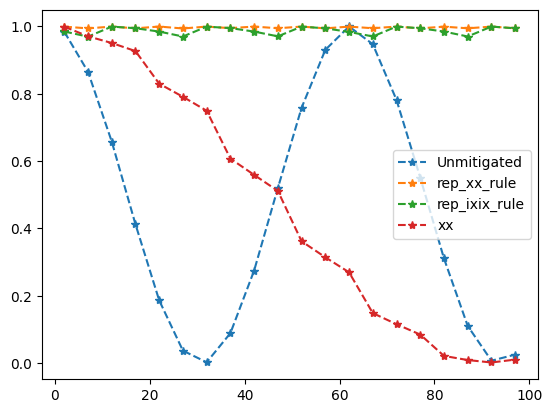

In [428]:
# Plot unmitigated
x, y = [], []
for res in data:
    if res[1] == "unmitigated":
        x.append(res[0])
        y.append(res[2])
plt.plot(x, y, "--*", label="Unmitigated")

# Plot xx
x, y = [], []
for res in data:
    if res[1] == "rep_xx_rule":
        x.append(res[0])
        y.append(res[2])
plt.plot(x, y, "--*", label="rep_xx_rule")

# Plot ixix
x, y = [], []
for res in data:
    if res[1] == "rep_ixix_rule":
        x.append(res[0])
        y.append(res[2])
plt.plot(x, y, "--*", label="rep_ixix_rule")

# Plot xx
x, y = [], []
for res in data:
    if res[1] == "xx":
        x.append(res[0])
        y.append(res[2])
plt.plot(x, y, "--*", label="xx")


plt.legend()

```{figure} ../_thumbnails/ddd_qiskit_ghz_plot.png
---

name: ddd-qiskit-ghz-plot-ibmq
---
Plot of the unmitigated and DDD-mitigated expectation values obtained from executing the corresponding circuits.
```

We can see that DDD improves the expectation value at each circuit depth, and the repeated XX sequence is the best at mitigating the errors
occurring during idle windows.